 $\Large \textbf{CONSTRUCTING VALID PREDICTION SETS WITH ACP}$

This notebook provides an introductory tutorial on Approximate full Conformal Prediction (ACP). The full details can be found in the accompanying paper:

Javier Abad, Umang Bhatt, Adrian Weller and Giovanni Cherubin. “Approximating Full Conformal Prediction at Scale via Influence Functions.” 2022.

$\textbf{CONSTRUCTING VALID PREDICTION SETS}$

Consider a training set $Z=(X, Y) \in(\mathcal{X} \times \mathcal{Y})^{N}$ of $N$ examples. For a test example $x \in \mathcal{X}$ and a chosen significance level $\varepsilon \in[0,1]$ a Conformal Predictor (CP) returns a set $\Gamma^{e} \subseteq \mathcal{Y}$ that contains $x$’s true label with probability at least $1-\varepsilon$. This guarantee (validity) holds for any exchangeable distribution on $Z \cup\{(x, y)\}$.

Particularly, full CP is a statistically powerful CP algorithm that attains the validity guarantees while also yielding tight prediction sets (i.e., high efficiency). Unfortunately,  full CP is notoriously computationally expensive. 

ACP consistently approximates full CP by leveraging Influence Functions (IF). Given a sufficiently large training set, ACP inherits the statistical power of full CP. This enables running full CP at a much reduced computational cost, and allows scaling it to large, real-world datasets. 

$\textbf{IMPORTING THE PACKAGES}$

In [1]:
from wrapper import *
from utils import *

SEED = 42 #for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

Using cuda device


$\textbf{DATA}$

We generate synthetic data for a 5-class classification problem using scikit-learn’s $\texttt{make_classification}() $. We sample points from five Gaussian-distributed clusters, one per class. Each object is defined by 10 features. This is a concrete toy example, but feel free to play around with different synthetic settings!

In [2]:
TRAIN_SIZE = 1000 #number of training points
TEST_SIZE = 10 #number of test points
N_CLASSES = 5 #number of classes
N_FEATURES = 10 #total number of features 
N_CLUSTERS = 1 #number of clusters per class
N_INFORMATIVE = 3 #number of informative features
N_REDUNDANT = 2 #number of redundant features

X, Y = make_classification(n_samples = TRAIN_SIZE + TEST_SIZE, n_features = N_FEATURES, n_classes = N_CLASSES,
                           n_clusters_per_class = N_CLUSTERS, n_informative = N_INFORMATIVE, random_state = SEED)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = TEST_SIZE, random_state = SEED)

$\textbf{FITTING A MODEL}$

It’s time to decide the underlying model on top of which we build ACP. Here we use a 2-layers neural network; however, you can plug in any model as long as it is differentiable.

In [3]:
#Instantiate model

NUM_NEURONS = [20,10] #layers and neurons for the NN classifier
REG = 0.01
model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES, seed = SEED, l2_reg = REG)

$\textbf{BUILDING ACP AND GENERATING PREDICTION SETS}$

ACP works as a wrapper for an ML model. We now instantiate ACP and generate prediction sets for a chosen significance level $\varepsilon$. These prediction sets are guaranteed to contain the true class label with confidence at least $1 – \varepsilon$.

In [4]:
#Building ACP (deleted)
ACP = ACP_D(Xtrain, Ytrain, model, seed = SEED, verbose = True)

Training model on 1000 samples
Epoch: 1 - Validation Loss: 2.6311
Epoch: 10 - Validation Loss: 2.0670
Epoch: 20 - Validation Loss: 1.7241
Epoch: 30 - Validation Loss: 1.4769
Epoch: 40 - Validation Loss: 1.3160
Epoch: 50 - Validation Loss: 1.2107
Epoch: 60 - Validation Loss: 1.1330
Epoch: 70 - Validation Loss: 1.0685
Epoch: 80 - Validation Loss: 1.0203
Epoch: 90 - Validation Loss: 0.9827
Epoch: 100 - Validation Loss: 0.9512
Epoch: 110 - Validation Loss: 0.9255
Epoch: 120 - Validation Loss: 0.9045
Epoch: 130 - Validation Loss: 0.8869
Epoch: 140 - Validation Loss: 0.8714
Epoch: 150 - Validation Loss: 0.8599
Epoch: 160 - Validation Loss: 0.8509
Epoch: 170 - Validation Loss: 0.8424
Epoch: 180 - Validation Loss: 0.8338
Epoch: 190 - Validation Loss: 0.8265
Epoch: 200 - Validation Loss: 0.8205
Computing gradients and Hessian inverse
Computing scores for 1000 samples
Conformal predictor is ready!


In [5]:
#Generate prediction sets that are guaranteed to contain the true class label with at least a specified probability 1-epsilon
eps = 0.1 # 1-0.1 = 0.9 confidence of including the true label
sets = ACP.predict(Xtest, eps, out_file = "results/test")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Computing p-values for 10 samples


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Let us now look at the generated prediction sets. They are guaranteed to contain the true label with the specified probability $1-\varepsilon$. 

In [6]:
print("Prediction sets: " + str(list(sets.values()))) #prediction sets
print()
print("True labels: " + str(Ytest)) #true labels

Prediction sets: [[0, 1], [3], [1], [4], [2], [0, 2], [3, 4], [2], [2], [1]]

True labels: [2 3 1 4 2 2 4 2 2 1]


$\textbf{VALIDITY AND EFFICIENCY OF ACP}$

ACP inherits the statistical power of full CP, constructing prediction sets that attain both validity guarantees and high statistical power (i.e., efficiency).

We obtain the accuracy of ACP, that is, the rate at which the true label is included in the prediction set. For $\varepsilon=0.1$, ACP achieves an accuracy of $90\%$.

In [9]:
result = pd.read_json("results/test", lines = True) #loading ACP p-values
accum_acc = compute_accum_acc(eps, result, Ytest) #computing accuracy for chosen epsilon 

print("ACP's accuracy: {}%".format(accum_acc[-1]/len(Ytest)*100))

ACP's accuracy: 90.0%


Naturally, ACP with $\varepsilon = 0.1$ is more accurate than just predicting the outcomes based on the raw model's outputs:

In [10]:
from sklearn.metrics import accuracy_score

print("Model's accuracy: {}%".format(accuracy_score(model.predict(Xtest), Ytest)*100))

Model's accuracy: 80.0%


We now consider a single test point chosen uniformly at random. We can plot how the prediction set size changes w.r.t $\varepsilon$ for ACP. We include the AUC for the interval $\varepsilon \in [0,0.2]$ and use it as a proxy of the efficiency (the lower the AUC, the higher the efficiency). This interval captures settings that are generally of practical interest. 

Additionally, we report with $\color{lightcoral}\bigstar$ the highest $\varepsilon$ for which the prediction set contains the true label.  A higher value indicates that, for this test example, the method would still be accurate with larger $\varepsilon$, which would correspond to tighter prediction sets. 

In [11]:
cand = random.randint(0, len(Ytest)-1) #Randomly picking an example from the test set
epsilons = np.arange(0,1.01,0.01) #Discretized x axis (epsilons)

curve = get_average_interval(result, cand, epsilons) #Computing prediction set size w.r.t epsilon
min_eps = find_min_epsilon(result, Ytest, cand, epsilons) #minimum epsilon that contains true label
AUC = round(simps(curve[:21], epsilons[:21]),3) #AUC for the interval [0, 0.2]

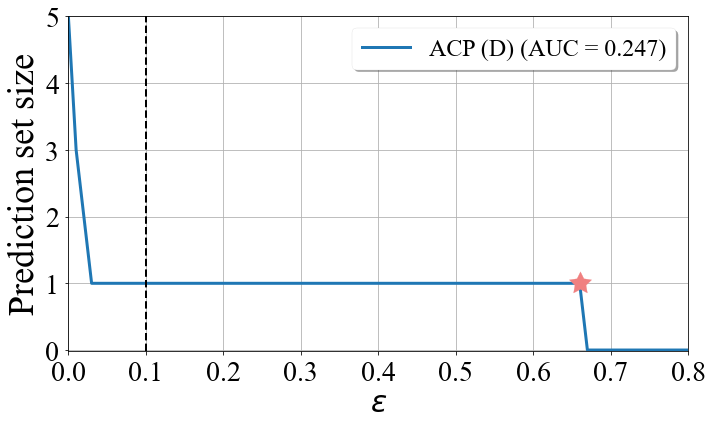

In [12]:
plt.style.use('seaborn-paper')
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))

plt.plot(epsilons, curve, label ="ACP (D) (AUC = {})".format(AUC), linewidth = 3)
plt.scatter(min_eps, curve[np.where(epsilons == min_eps)[0][0]], s=550, marker=(5, 1), color = "lightcoral", zorder = 3)

plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, np.round(min_eps,1) + 0.1])
plt.ylim([-0.01, N_CLASSES])
plt.xticks(np.arange(0, np.round(min_eps,1) + 0.2, 0.1), fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")
plt.axvline(x=eps, color = "black", linewidth = 2, linestyle = "--")

plt.grid()
plt.tight_layout()

We can measure the efficiency on the whole test set by averaging across points. Again, we report the AUC in $\varepsilon \in [0,0.2]$.

In [13]:
curve_all = epsilon_curves(result, epsilons) #average prediction set size w.r.t epsilon
AUC_all = round(simps(curve_all[:21], epsilons[:21]),3) #AUC

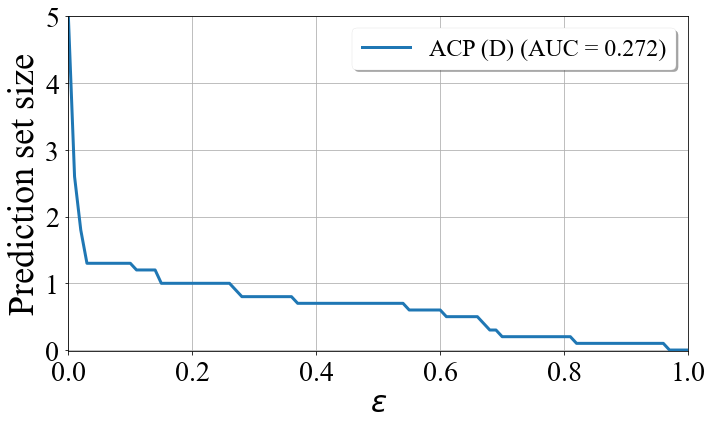

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(epsilons, curve_all, label ="ACP (D) (AUC = {})".format(AUC_all), linewidth = 3)
plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, 1.0])
plt.ylim([-0.01, N_CLASSES])
plt.xticks(fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")

plt.grid()
plt.tight_layout()

$\textbf{EFFICIENCY COMPARISON}$

We now consider main-stream CP alternatives, and compare them empirically with ACP on the basis of their predictive power (efficiency). We study split CP (SCP), RAPS and CV+. We keep the same underlying classifier.

In [15]:
#SCP

from others import split_cp

model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES, 
                      seed = SEED, l2_reg = REG).to(device)
_, _ = split_cp(model, Xtrain, Ytrain, Xtest, labels=np.unique(Ytrain).tolist(), out_file = "results/test_split_cp", 
                validation_split = 0.2)

result_split_cp = pd.read_json("results/test_split_cp", lines = True) #load p-values
curve_all_split_cp = epsilon_curves(result_split_cp, epsilons) #average prediction set size w.r.t epsilon
AUC_all_split_cp = round(simps(curve_all_split_cp[:21], epsilons[:21]),3) #AUC

Epoch: 1 - Validation Loss: 2.5670
Epoch: 10 - Validation Loss: 2.1020
Epoch: 20 - Validation Loss: 1.7851
Epoch: 30 - Validation Loss: 1.5303
Epoch: 40 - Validation Loss: 1.3565
Epoch: 50 - Validation Loss: 1.2445
Epoch: 60 - Validation Loss: 1.1695
Epoch: 70 - Validation Loss: 1.1158
Epoch: 80 - Validation Loss: 1.0719
Epoch: 90 - Validation Loss: 1.0301
Epoch: 100 - Validation Loss: 1.0038
Epoch: 110 - Validation Loss: 0.9739
Epoch: 120 - Validation Loss: 0.9516
Epoch: 130 - Validation Loss: 0.9343
Epoch: 140 - Validation Loss: 0.9195
Epoch: 150 - Validation Loss: 0.9007
Epoch: 160 - Validation Loss: 0.8921
Epoch: 170 - Validation Loss: 0.8803
Epoch: 180 - Validation Loss: 0.8658
Epoch: 190 - Validation Loss: 0.8567
Epoch: 200 - Validation Loss: 0.8511


In [16]:
#RAPS

from third_party.RAPS.RAPS_conformal import *

model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES,
                      seed = SEED, l2_reg = REG).to(device)
Xtrain_prop, Xval, Ytrain_prop, Yval = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = SEED)
model.fit(Xtrain_prop, Ytrain_prop, seed = SEED) #training on proper training set
calib_loader = torch.utils.data.DataLoader(create_set(Xval, Yval), batch_size=128, shuffle=True, pin_memory=True) #calib data
sizes = {}
for i, epsilon in enumerate(epsilons): #repeat for each epsilon
    cmodel = ConformalModel(model, calib_loader, alpha=epsilon, lamda_criterion='size', allow_zero_sets=True) #building RAPS
    
    for j in range(len(Ytest)):
        _, set = cmodel(check_tensor(np.expand_dims(Xtest[j], axis=0)).to(device)) #constructing prediction sets
        
        if epsilon not in sizes:
            sizes[epsilon] = [len(list(set[0]))]
        else:
            sizes[epsilon].append(len(list(set[0])))
    
curve_all_RAPS = [np.mean(sizes[epsilon]) for epsilon in sizes] #average prediction set size w.r.t epsilon
AUC_all_RAPS = round(simps(curve_all_RAPS[:21], epsilons[:21]),3) #AUC

Epoch: 1 - Validation Loss: 2.5670
Epoch: 10 - Validation Loss: 2.1020
Epoch: 20 - Validation Loss: 1.7851
Epoch: 30 - Validation Loss: 1.5303
Epoch: 40 - Validation Loss: 1.3565
Epoch: 50 - Validation Loss: 1.2445
Epoch: 60 - Validation Loss: 1.1695
Epoch: 70 - Validation Loss: 1.1158
Epoch: 80 - Validation Loss: 1.0719
Epoch: 90 - Validation Loss: 1.0301
Epoch: 100 - Validation Loss: 1.0038
Epoch: 110 - Validation Loss: 0.9739
Epoch: 120 - Validation Loss: 0.9516
Epoch: 130 - Validation Loss: 0.9343
Epoch: 140 - Validation Loss: 0.9195
Epoch: 150 - Validation Loss: 0.9007
Epoch: 160 - Validation Loss: 0.8921
Epoch: 170 - Validation Loss: 0.8803
Epoch: 180 - Validation Loss: 0.8658
Epoch: 190 - Validation Loss: 0.8567


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 495.58it/s]

Epoch: 200 - Validation Loss: 0.8511
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973188161849976
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970964908599854



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.87it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974798679351807
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971707582473755



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.09it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297473669052124
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974791526794434


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.13it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974460124969482
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974650859832764


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 401.18it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975374460220337
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973519563674927



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.03it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972733974456787
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974302768707275
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.25it/s]


Computing logits for model (only happens once).
Optimal T=1.2971829175949097
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973366975784302


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.04it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297360897064209
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972776889801025


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.10it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970017194747925
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976771593093872


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.95it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973579168319702
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297433853149414
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.71it/s]


Computing logits for model (only happens once).
Optimal T=1.297048807144165
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973729372024536
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.01it/s]


Computing logits for model (only happens once).
Optimal T=1.297621488571167
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973099946975708


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.95it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972809076309204
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971653938293457


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.86it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297346591949463
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974915504455566


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.98it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.29725182056427
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297269344329834
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.89it/s]


Optimal T=1.2974460124969482
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974084615707397
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.72it/s]


Computing logits for model (only happens once).
Optimal T=1.2973929643630981
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297518014907837


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 502.13it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973302602767944
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976725101470947


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.78it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974978685379028
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297617793083191



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 394.96it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.298241376876831
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972431182861328


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.08it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973392009735107
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972544431686401


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.62it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974588871002197
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972010374069214



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.16it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2978899478912354
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975167036056519
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.44it/s]


Computing logits for model (only happens once).
Optimal T=1.2972978353500366
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976809740066528
Begin Platt scaling.

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.45it/s]


Computing logits for model (only happens once).
Optimal T=1.2973819971084595
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974926233291626
Begin Platt scaling.



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.19it/s]


Computing logits for model (only happens once).
Optimal T=1.2972356081008911
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971307039260864
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.98it/s]

Optimal T=1.297628402709961
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297758936882019
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.09it/s]


Optimal T=1.2970008850097656
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974770069122314
Begin Platt scaling.


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Computing logits for model (only happens once).
Optimal T=1.2976391315460205
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2978582382202148
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.30it/s]


Optimal T=1.2974088191986084
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297268271446228
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 665.82it/s]

Computing logits for model (only happens once).
Optimal T=1.2978554964065552
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975497245788574
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.22it/s]


Optimal T=1.2970860004425049
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975542545318604
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.08it/s]


Computing logits for model (only happens once).
Optimal T=1.297382116317749
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.29744291305542
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.92it/s]


Optimal T=1.297291874885559
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975159883499146
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.08it/s]


Optimal T=1.2976092100143433
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975876331329346
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.01it/s]


Computing logits for model (only happens once).
Optimal T=1.2975786924362183
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971653938293457
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.62it/s]


Optimal T=1.2976526021957397
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974516153335571
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 660.21it/s]


Computing logits for model (only happens once).
Optimal T=1.297850489616394
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971857786178589
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.19it/s]


Optimal T=1.2973291873931885
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976106405258179
Begin Platt scaling.


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Computing logits for model (only happens once).
Optimal T=1.2976864576339722
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972338199615479
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.27it/s]


Optimal T=1.297615647315979
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2977243661880493
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.27it/s]


Optimal T=1.297289252281189
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973583936691284
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.86it/s]


Computing logits for model (only happens once).
Optimal T=1.2972508668899536
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297642469406128
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.27it/s]


Computing logits for model (only happens once).
Optimal T=1.2970714569091797
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297222375869751
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 503.82it/s]


Computing logits for model (only happens once).
Optimal T=1.2973774671554565
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970860004425049
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.80it/s]


Optimal T=1.2973700761795044
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974274158477783
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.77it/s]


Optimal T=1.297433853149414
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297358751296997
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.19it/s]


Computing logits for model (only happens once).
Optimal T=1.2974672317504883
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972524166107178
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.07it/s]


Computing logits for model (only happens once).
Optimal T=1.2976396083831787
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2969632148742676
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 659.74it/s]


Computing logits for model (only happens once).
Optimal T=1.2970777750015259
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2978150844573975
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 496.28it/s]

Computing logits for model (only happens once).
Optimal T=1.2975313663482666


In [17]:
#CV+

from third_party.ARC.arc import models, methods, black_boxes, coverage

model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES,
                      seed = SEED, l2_reg = REG).to(device)
method_cv = methods.CVPlus(Xtrain, Ytrain, model, n_folds=5, seed = SEED, verbose = False) #building CV+
sizes = {}

for i, epsilon in enumerate(epsilons): #repeat for each epsilon
        for j in range(len(Ytest)):
            set = method_cv.predict(check_tensor(np.expand_dims(Xtest[j], axis=0)).to(device), alpha = epsilon) #constructing prediction sets
        
            if epsilon not in sizes:
                sizes[epsilon] = [len(list(set[0]))]
            else:
                sizes[epsilon].append(len(list(set[0])))
            
curve_all_CV_plus = [np.mean(sizes[epsilon]) for epsilon in sizes] #average prediction set size w.r.t epsilon
AUC_all_CV_plus = round(simps(curve_all_CV_plus[:21], epsilons[:21]),3) #AUC

Epoch: 1 - Validation Loss: 2.6536
Epoch: 10 - Validation Loss: 2.1385
Epoch: 20 - Validation Loss: 1.8121
Epoch: 30 - Validation Loss: 1.5520
Epoch: 40 - Validation Loss: 1.3452
Epoch: 50 - Validation Loss: 1.2091
Epoch: 60 - Validation Loss: 1.1107
Epoch: 70 - Validation Loss: 1.0387
Epoch: 80 - Validation Loss: 0.9799
Epoch: 90 - Validation Loss: 0.9319
Epoch: 100 - Validation Loss: 0.8971
Epoch: 110 - Validation Loss: 0.8652
Epoch: 120 - Validation Loss: 0.8370
Epoch: 130 - Validation Loss: 0.8129
Epoch: 140 - Validation Loss: 0.7937
Epoch: 150 - Validation Loss: 0.7780
Epoch: 160 - Validation Loss: 0.7667
Epoch: 170 - Validation Loss: 0.7538
Epoch: 180 - Validation Loss: 0.7406
Epoch: 190 - Validation Loss: 0.7343
Epoch: 200 - Validation Loss: 0.7248
Epoch: 1 - Validation Loss: 2.7521
Epoch: 10 - Validation Loss: 2.2219
Epoch: 20 - Validation Loss: 1.9052
Epoch: 30 - Validation Loss: 1.6522
Epoch: 40 - Validation Loss: 1.4761
Epoch: 50 - Validation Loss: 1.3527
Epoch: 60 - Validat

We measure the efficiency with the  AUC in the interval $\varepsilon \in [0,0.2]$ (the lower the AUC; the higher the efficiency). ACP is consistently better than existing alternatives in terms of statistical power: it attains the desired error rate with tighter prediction sets. 

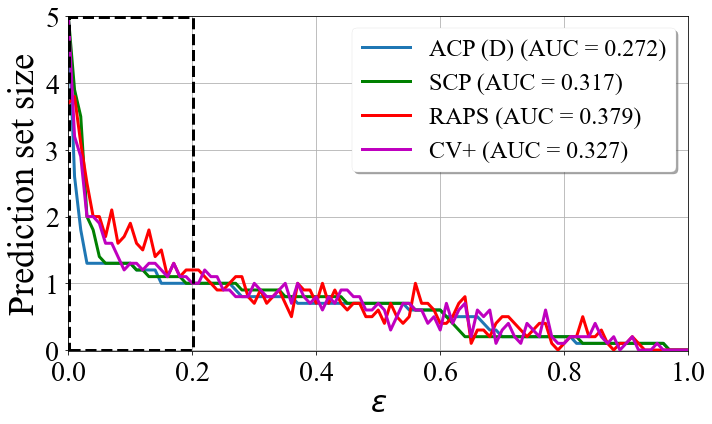

In [18]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(epsilons, curve_all, label ="ACP (D) (AUC = {})".format(AUC_all), linewidth = 3)
plt.plot(epsilons, curve_all_split_cp, label ="SCP (AUC = {})".format(AUC_all_split_cp), linewidth = 3, color="green")
plt.plot(epsilons, curve_all_RAPS, label ="RAPS (AUC = {})".format(AUC_all_RAPS), linewidth = 3, color = "red")
plt.plot(epsilons, curve_all_CV_plus, label ="CV+ (AUC = {})".format(AUC_all_CV_plus), linewidth = 3, color = "m")

rect = patches.Rectangle((0.001,0), 0.2, N_CLASSES - 0.01, ls="--", linewidth=3, edgecolor='black', facecolor='none', zorder = 5)
ax.add_patch(rect)

plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, 1.0])
plt.ylim([-0.01, N_CLASSES])
plt.xticks(fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")

plt.grid()
plt.tight_layout()

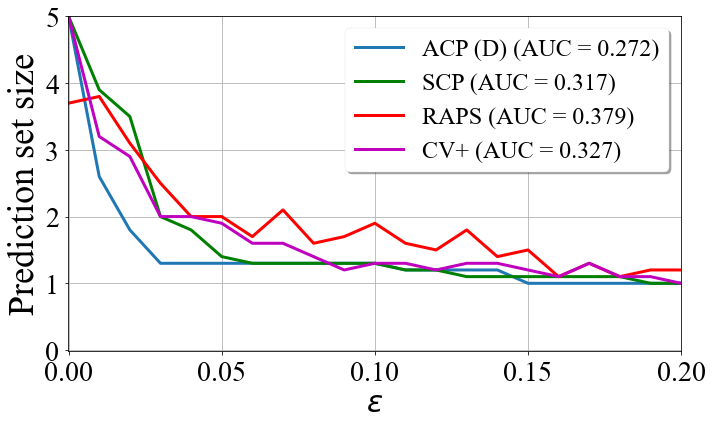

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(epsilons[:21], curve_all[:21], label ="ACP (D) (AUC = {})".format(AUC_all), linewidth = 3)
plt.plot(epsilons[:21], curve_all_split_cp[:21], label ="SCP (AUC = {})".format(AUC_all_split_cp), linewidth = 3, color="green")
plt.plot(epsilons[:21], curve_all_RAPS[:21], label ="RAPS (AUC = {})".format(AUC_all_RAPS), linewidth = 3, color = "red")
plt.plot(epsilons[:21], curve_all_CV_plus[:21], label ="CV+ (AUC = {})".format(AUC_all_CV_plus), linewidth = 3, color = "m")

plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, 0.2])
plt.ylim([-0.01, N_CLASSES])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2], fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")

plt.grid()
plt.tight_layout()